In [1]:
from scripts import bookdatafunctions as bdf
import pandas as pd
import seaborn as sns
import matplotlib
import warnings
from tqdm import tqdm
from scipy.stats import bootstrap
from resample.bootstrap import resample
import numpy as np
from pprint import pprint
from time import perf_counter
warnings.filterwarnings('ignore')

In [2]:
#Constants

#Number of rounds to bootstrap
RUNS = 10000

#Meaningful effect size for Cohen's d
MES = 0.79

#In how big a proportion do feats need to appear in to be considered consistant

CONSISTANT = 0.85

#In the deprel column
#Dependency relation types in Finnish UD
DEPRELS = ['root', 'nsubj', 'advmod', 'obl', 'obj', 'conj', 'aux', 'cc', 'amod', 'nmod:poss', 'mark', 'cop', 'nsubj:cop', 'advcl', 'xcomp', 'case', 'det', 'ccomp', 'nmod', 'parataxis', 'acl:relcl', 'acl', 'xcomp:ds', 'discourse', 'nummod', 'fixed', 'cop:own', 'appos', 'flat:name', 'compound:nn', 'aux:pass', 'vocative', 'nmod:gobj', 'nmod:gsubj', 'compound:prt', 'csubj:cop', 'flat:foreign', 'orphan', 'cc:preconj', 'csubj', 'compound', 'flat', 'goeswith']

#In the feats column
#Cases in Finnihs UD
CASES = ['Case=Nom', 'Case=Gen', 'Case=Par', 'Case=Ill', 'Case=Ine', 'Case=Ela', 'Case=Ade', 'Case=All', 'Case=Ess', 'Case=Abl', 'Case=Tra', 'Case=Acc', 'Case=Ins', 'Case=Abe', 'Case=Com']
#Verb forms in Finnish UD
VERBFORMS = ['VerbForm=Fin', 'VerbForm=Inf', 'VerbForm=Part']
#Verb tenses in Finnish UD
VERBTENSES = ['Tense=Pres', 'Tense=Past']
#Verb voices in Finnish UD
VERBVOICES = ['Voice=Act', 'Voice=Pass']
#Verb moods in Finnish UD
VERBMOODS = ['Mood=Ind', 'Mood=Cnd', 'Mood=Imp']
#Verb 'person' in Finnish UD (aka first person, second person and so on)
PERSONS = ['Person=0', 'Person=1', 'Person=2', 'Person=3']
#Verb 'number' in Finnish UD (aka first singluar person [me] or first plural person [we] and so on)
NUMBERS = ['Number=Sing', 'Number=Plur']
#Connegative (aka verb that has been given a negative meaning by 'ei')
CONNEGATIVE = ['Connegative=Yes']
#Degrees in Finnish UD (positive, comparative, and superlative)
DEGREES = ['Degree=Pos','Degree=Cmp','Degree=Sup']
#Syles in Finnish UD
STYLES = ['Style=Arch', 'Style=Coll']
#Reflex pronouns in Finnish UD
REFS = ['Reflex=Yes']
#PronTypes in Finnish UD
PRONTYPES = ['PronType=Dem', 'PronType=Ind', 'PronType=Int', 'PronType=Prs', 'PronType=Rcp', 'PronType=Rel']
#Verb polarity in Finnish UD
POLARITY = ['Polarity=Neg']
#Person possessor in Finnish UD (e.g. luu VS. luumme)
PPSORS = ['Person[psor]=1', 'Person[psor]=2', 'Person[psor]=3']
#Partforms in Finnish UD
PARTFORMS = ['PartForm=Agt', 'PartForm=Neg', 'PartForm=Past', 'PartForm=Pres']
#Number types in Finnish UD
NUMTYPES = ['NumType=Card', 'NumType=Ord']
#Numeral posessor in Finnish UD (e.g. aikani VS. aikanamme)
NPSORS = ['Number[psor]=Plur', 'Number[psor]=Sing']
#Infinitive forms for verbs in Finnish UD
INFFORMS = ['InfForm=1', 'InfForm=2', 'InfForm=3']
#Marks foreign words in Finnish UD
FOREIGN = ['Foreign=Yes']
#Derivations of words in Finnish UD
DERIVATIONS = ['Derivation=Inen', 'Derivation=Ja', 'Derivation=Lainen', 'Derivation=Llinen', 'Derivation=Tar', 'Derivation=Ton', 'Derivation=Ttain', 'Derivation=U', 'Derivation=Vs', 'Derivation=Inen|Vs' 'Derivation=Ja|Tar', 'Derivation=Lainen|Vs', 'Derivation=Llinen|Vs', 'Derivation=Ton|Vs']
#Clitics of words in Finnish UD
CLITICS = ['Cilitic=Han', 'Cilitic=Ka', 'Cilitic=Kaan', 'Cilitic=Kin', 'Cilitic=Ko', 'Cilitic=Pa', 'Cilitic=S', 'Cilitic=Han|Kin', 'Cilitic=Han|Ko', 'Cilitic=Han|Pa', 'Cilitic=Ko|S', 'Cilitic=Pa|S']
#AdpTypes in Finnish UD
ADPTYPES = ['AdpType=Post', 'AdpType=Prep']
#Marks if words are abbrevations in Finnish UD
ABBR = ['Abbr=Yes']

FEATS = CASES + VERBFORMS + VERBTENSES + VERBVOICES + VERBMOODS + PERSONS + NUMBERS + CONNEGATIVE + DEGREES + STYLES + REFS + PRONTYPES + POLARITY + PPSORS + PARTFORMS + NUMTYPES + NPSORS + INFFORMS + FOREIGN + DERIVATIONS + CLITICS + ADPTYPES + ABBR
#In the upos column
#POS tags in Finnish UD
POS = ['NOUN', 'VERB', 'PRON', 'ADV', 'AUX', 'ADJ', 'PROPN', 'CCONJ', 'SCONJ', 'ADP', 'NUM', 'INTJ', 'PUNCT']


CONLLU_FEATS = DEPRELS + FEATS + POS 


ALL_FEATS = DEPRELS + FEATS + POS 
ALL_FEATS += ['TTR', 'MLS', 'C2S', 'NPS', 'VPS', 'ADJPS', 'ADVPS', 'F-K']

ISBN2AGE_PATH = "ISBN_MAPS/ISBN2AGE.xlsx"

In [3]:
#Nab corpus and transform ages
corpus = bdf.mapGroup2Age(bdf.initBooksFromConllus("Conllus"), ISBN2AGE_PATH)

In [4]:
#Define sub-corpora

ages = sorted(bdf.getAvailableAges(corpus))
#Generate correct keys/ids
group_1 = [5,6,7,8]
group_2 = [9,10,11,12]
group_3 = [a for a in ages if a>12]
#Distinct subcorpora
sub_corp_1= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_1])
sub_corp_2= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_2])
sub_corp_3= bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x) for x in group_3])
sub_corps = dict(zip(['1','2','3'],[sub_corp_1, sub_corp_2, sub_corp_3]))

In [5]:
def getFleschKincaid(corpus: dict):
    returnable = {}
    ASL = bdf.getAvgSentenceLens(corpus)
    for id in corpus:
        df = corpus[id]
        ASW = np.mean(pd.Series(data=df['text'].apply(bdf.countSyllablesFinnish).to_numpy(), index=df['text'].to_numpy(dtype='str')).to_numpy(na_value=0))
        returnable[id] = 0.39*ASL[id] + 11.8*ASW - 15.59
    
    return returnable

In [6]:
#Prep feature amounts etc. to hopefully speed up calculations

#Data structure will be dict[num,dict[id,dict[feat,value]]]
sub_corps_values = {}
for sub_corp in sub_corps:
    sub_corp_values = {}
    with tqdm(range(len(sub_corps[sub_corp])), desc="Iterating over subcorp...") as pbar:
        for book in sub_corps[sub_corp]:
            temp_book = {'1':sub_corps[sub_corp][book]}
            book_values = {}
            for deprel in DEPRELS:
                book_values[deprel] = bdf.getDeprelFeaturePerBook(temp_book, deprel, True)['1']
            for feat in FEATS:
                book_values[feat] = bdf.getFeatsFeaturePerBook(temp_book, feat, True)['1']
            for pos in POS:
                book_values[pos] = bdf.getPosFeaturePerBook(temp_book, pos, True)['1']
            #Monster of a line for TTRs
            book_values['TTR'] = bdf.getTypeTokenRatios(bdf.getWordFrequencies(temp_book), bdf.getTokenAmounts(temp_book))['1']
            #MLS
            book_values['MLS'] = bdf.getAvgSentenceLens(temp_book)['1']
            #CONJ2Sent
            book_values['C2S'] = bdf.getConjPerSentence(temp_book)['1']
            #Phrase ratios
            sent_am_1 = bdf.getNumOfSentences(temp_book)
            book_values['NPS'] = bdf.scaleCorpusData(bdf.getPosPhraseCounts(temp_book, 'NOUN'), sent_am_1)['1']
            book_values['VPS'] = bdf.scaleCorpusData(bdf.getPosPhraseCounts(temp_book, 'VERB'), sent_am_1)['1']
            book_values['ADJPS'] = bdf.scaleCorpusData(bdf.getPosPhraseCounts(temp_book, 'ADJ'), sent_am_1)['1']
            book_values['ADVPS'] = bdf.scaleCorpusData(bdf.getPosPhraseCounts(temp_book, 'ADV'), sent_am_1)['1']
            #Flesch-Kincaid readability score
            book_values['F-K'] = getFleschKincaid(temp_book)['1']
            #Save to sub_corp's dict
            sub_corp_values[book] = book_values
            pbar.update(1)
        #Save to sub_corps' dict
    sub_corps_values[sub_corp] = sub_corp_values

Iterating over subcorp...: 100%|██████████| 100/100 [02:16<00:00,  1.36s/it]


In [7]:
#Using resample's bootstrapping method to gain lists of keys for each subcorp
bootstrapped_books = {j: [x for x in resample(list(sub_corps[j].keys()), size=RUNS)] for j in sub_corps}

In [8]:
#Some helper functions for this notebook
import math
def cohensdForValues(data1: list[float], data2: list[float]) -> float:
    #Sample size
    n1, n2 = len(data1), len(data2)
    #Variance
    s1, s2 = np.var(data1, ddof=1), np.var(data2, ddof=1)
    #Pooled standard deviation
    s = math.sqrt( ((n1-1)*s1 + (n2-1)*s2)/(n1+n2-2) )
    #Return Cohen's d
    return ((np.mean(data1)-np.mean(data2)) / s)

def valueListFromKeys(values, keys, feat):
    return [values[key][feat] for key in keys]

def sub_columns(columns: list[str], start: str) -> list[str]:
    return [c for c in columns if c[0:len(start)] == start]

In [9]:
effect_sizes_per_run = {}
with tqdm(range(RUNS), desc="Iterating over bootstrapped subcorpora...") as pbar:
    for i in range(RUNS):
        effect_sizes = {}
        for key1 in sub_corps:
            books_1 = bootstrapped_books[key1][i]
            values_1 = sub_corps_values[key1]
            for key2 in sub_corps:
                new_key = str(key1)+" vs. "+str(key2)
                #If keys are the same, then d will be 0 always so save computing time
                if key1 == key2:
                    effect_sizes[new_key] = [0]*len(ALL_FEATS)
                    continue
                books_2 = bootstrapped_books[key2][i]
                values_2 = sub_corps_values[key2]
                #Oneliner that calculates Cohen's d for all feats between bootstrapped subcorps
                effect_sizes_temp = [cohensdForValues(valueListFromKeys(values_1, books_1, feat), valueListFromKeys(values_2, books_2, feat)) for feat in ALL_FEATS]
                effect_sizes[new_key] = effect_sizes_temp
        effect_sizes_per_run[i] = effect_sizes
        pbar.update(1)

Iterating over bootstrapped subcorpora...: 100%|██████████| 10000/10000 [10:12<00:00, 16.31it/s]


In [10]:
#Function for calculating which features are classified as somewhat meaningful for a set of cohen's d values
def meaningfulFeats(meaningful_ef_size, ef_df):
    sep_between_two = []
    for feat in ALL_FEATS:
        for corp1 in [1,2,3]:
            for corp2 in [0,1,2]:
                perf_counter()
                temp_df = ef_df[sub_columns(ef_df.columns, str(corp1))]
                y_1 = temp_df[temp_df.columns[corp2:min(corp2+1,2)]].loc[feat].to_numpy(na_value=0.0)
                if ((abs(y_1)>meaningful_ef_size).sum() > 0):
                    sep_between_two.append(feat)
    sep_between_rest = []
    for feat in ALL_FEATS:
        for corp1 in [0,1,2]:
                temp_df = ef_df[sub_columns(ef_df.columns, str(corp1+1))]
                temp_list = [0,1,2]
                temp_list.remove(corp1)
                ts = []
                for t in temp_list:
                    ts.append(np.nan_to_num(temp_df[temp_df.columns[t]].loc[feat], nan=0.0))
                if ((abs(np.array(ts))>meaningful_ef_size-0.5).sum() > 1):
                    sep_between_rest.append(feat)
    between_2_3 = []
    for feat in ALL_FEATS:
        temp_df = ef_df[sub_columns(ef_df.columns, '2')]
        y_1 = temp_df[temp_df.columns[2:]].loc[feat].to_numpy(na_value=0.0)
        if ((abs(y_1)>meaningful_ef_size-0.3).sum() > 0):
            between_2_3.append(feat)

    return list(set(sep_between_two+sep_between_rest+between_2_3))

In [11]:
print(effect_sizes_per_run[0])

{'1 vs. 1': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], '1 vs. 2': [nan, -0.21615956937790118, -0.23319246994098003, -0.5662487659803124, -0.5498518517373261, -0.254840047222108, -0.4234996259259605, -0.2802465600882745, -0.222840474836262, -0.4884974730666869, -0.5009949148655101, -0.2848760521678052, -0.2716701669050135, -0.44811781365571607, -0.4960241122245412, -0.5262240596518898, -0.3188501840514891, -0.5699693159533228, -0.33591175835663556, 0.3929313854587874, -0.5675931739288528, -0.417247750862168, -0.5267636225905342, -0.06305402244674013, -0.19081587107264994, -0.2662

In [12]:
#Function for calculating which features are classified as somewhat meaningful for a set of cohen's d values
def meaningfulFeats(meaningful_ef_size, ef_sizes):

    sep_between_two = []
    for corp in ef_sizes:
        y_1 = abs(np.nan_to_num(ef_sizes[corp]))
        for i in range(len(ALL_FEATS)):
            if y_1[i]>=meaningful_ef_size:
                sep_between_two.append(ALL_FEATS[i])

    return list(set(sep_between_two))

In [13]:
meaningful_feats_strong = []
meaningful_feats_medium = []
meaningful_feats_weak = []
with tqdm(range(RUNS), desc="Calculating meaningful effects per run...") as pbar:
    for i in effect_sizes_per_run:
        meaningful_feats_strong.append(meaningfulFeats(0.79, effect_sizes_per_run[i]))
        meaningful_feats_medium.append(meaningfulFeats(0.49, effect_sizes_per_run[i]))
        meaningful_feats_weak.append(meaningfulFeats(0.29, effect_sizes_per_run[i]))
        pbar.update(1)

Calculating meaningful effects per run...: 100%|██████████| 10000/10000 [00:13<00:00, 761.57it/s]


In [14]:
from collections import Counter
import itertools

print("Strong ef size: ",Counter(list(itertools.chain.from_iterable(meaningful_feats_strong))))
feat_counts_strong = dict(Counter(list(itertools.chain.from_iterable(meaningful_feats_strong))))
print("Medium ef size: ",Counter(list(itertools.chain.from_iterable(meaningful_feats_medium))))
feat_counts_medium = dict(Counter(list(itertools.chain.from_iterable(meaningful_feats_medium))))
print("Weak ef size: ",Counter(list(itertools.chain.from_iterable(meaningful_feats_weak))))
feat_counts_weak = dict(Counter(list(itertools.chain.from_iterable(meaningful_feats_weak))))

Strong ef size:  Counter({'Reflex=Yes': 8792, 'ccomp': 8598, 'Derivation=Ton': 7567, 'Number[psor]=Sing': 6674, 'TTR': 5424, 'Person[psor]=1': 5121, 'Polarity=Neg': 3322, 'Connegative=Yes': 2667, 'Person=1': 2625, 'aux': 2596, 'Derivation=Vs': 2503, 'Case=Abe': 2319, 'AUX': 2080, 'SCONJ': 1663, 'mark': 1591, 'VerbForm=Part': 1494, 'parataxis': 1197, 'Case=Acc': 1152, 'obj': 1143, 'vocative': 1082, 'Derivation=Llinen': 862, 'csubj': 809, 'Tense=Pres': 732, 'InfForm=3': 652, 'PartForm=Past': 638, 'Number=Sing': 636, 'PRON': 479, 'nmod:gsubj': 477, 'Case=Ela': 466, 'xcomp': 456, 'PronType=Rel': 370, 'Case=Ine': 366, 'Mood=Cnd': 364, 'InfForm=1': 358, 'cop': 350, 'PronType=Ind': 324, 'VerbForm=Inf': 292, 'Case=Ill': 255, 'Style=Coll': 255, 'Voice=Act': 248, 'Case=Abl': 239, 'xcomp:ds': 232, 'PartForm=Pres': 213, 'MLS': 207, 'nmod': 194, 'Case=Gen': 187, 'PartForm=Agt': 161, 'acl:relcl': 154, 'Degree=Pos': 140, 'acl': 121, 'obl': 115, 'VerbForm=Fin': 110, 'PUNCT': 104, 'PronType=Prs': 85, '

In [15]:
consistent_strong_feats = [feat for feat in feat_counts_strong if feat_counts_strong[feat]/RUNS > CONSISTANT]
consistent_medium_feats = [feat for feat in feat_counts_medium if feat_counts_medium[feat]/RUNS > CONSISTANT]
consistent_weak_feats = [feat for feat in feat_counts_weak if feat_counts_weak[feat]/RUNS > CONSISTANT]

In [16]:
print("Consistently at least strong features: ",consistent_strong_feats)
print("Consistently at least medium features: ",consistent_medium_feats)
print("Consistently at least weak features: ",consistent_weak_feats)

Consistently at least strong features:  ['ccomp', 'Reflex=Yes']
Consistently at least medium features:  ['Derivation=Vs', 'SCONJ', 'Derivation=Llinen', 'Case=Abe', 'ccomp', 'parataxis', 'aux', 'Person[psor]=1', 'AUX', 'nmod:gsubj', 'Connegative=Yes', 'Derivation=Ton', 'Reflex=Yes', 'Polarity=Neg', 'TTR', 'VerbForm=Part', 'Number[psor]=Sing', 'vocative', 'Person=1', 'Style=Coll']
Consistently at least weak features:  ['Case=Abl', 'SCONJ', 'ccomp', 'compound:nn', 'xcomp:ds', 'PartForm=Pres', 'Polarity=Neg', 'TTR', 'VerbForm=Part', 'PartForm=Agt', 'Number[psor]=Sing', 'Case=Acc', 'acl', 'Voice=Act', 'Mood=Cnd', 'vocative', 'Number=Sing', 'csubj', 'cop', 'Case=Gen', 'InfForm=1', 'obl', 'VerbForm=Inf', 'PUNCT', 'Person=1', 'Case=Ela', 'nmod:gobj', 'PartForm=Past', 'aux', 'Person[psor]=1', 'det', 'nmod', 'conj', 'Tense=Pres', 'Derivation=Ton', 'InfForm=3', 'VerbForm=Fin', 'MLS', 'obj', 'acl:relcl', 'PRON', 'Derivation=Llinen', 'Case=Abe', 'Style=Coll', 'PronType=Ind', 'xcomp', 'AUX', 'nmod:g

In [29]:
means = {}
for j in range(9):
    for i in effect_sizes_per_run:
        to_mean = []
        es = effect_sizes_per_run[i]
        to_mean.append(np.nan_to_num(np.array(list(es.values())[j])))
    means[list(es.keys())[j]] = np.median(to_mean, axis=0)

In [63]:
ef_df = pd.DataFrame(means, index=ALL_FEATS)
testing_df = ef_df.copy()
print(len(testing_df))
#remove = ['root']
# ,
most_important = ['ccomp','vocative', 'nmod','nmod:gsubj','VerbForm=Part','Connegative=Yes', 'CCONJ', 'AUX','nummod','compound:nn', 'nsubj', 'Person=3', 'Case=Abe']
#most_important = consistent_strong_feats
most_important = consistent_medium_feats
#most_important = consistent_weak_feats
to_drop = [x for x in ALL_FEATS if x not in most_important]
print(most_important)
testing_df_edited = testing_df.drop(to_drop)
print(len(testing_df_edited))

152
['Derivation=Vs', 'SCONJ', 'Derivation=Llinen', 'Case=Abe', 'ccomp', 'parataxis', 'aux', 'Person[psor]=1', 'AUX', 'nmod:gsubj', 'Connegative=Yes', 'Derivation=Ton', 'Reflex=Yes', 'Polarity=Neg', 'TTR', 'VerbForm=Part', 'Number[psor]=Sing', 'vocative', 'Person=1', 'Style=Coll']
20


<Axes: >

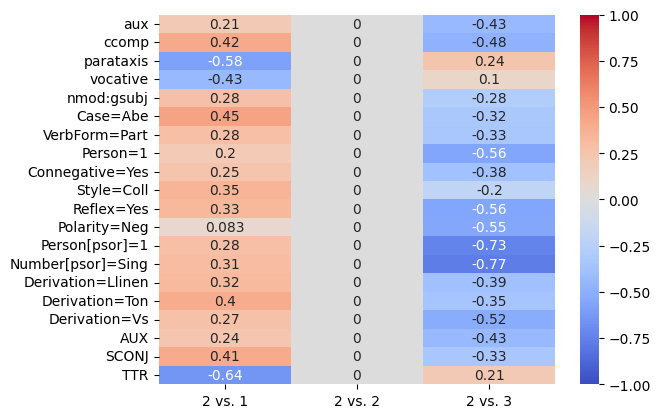

In [74]:
sns.heatmap(testing_df_edited[sub_columns(ef_df.columns, '2')], cmap='coolwarm', vmin=-1, vmax=1, annot=True)

In [65]:
def testTTR(corpus: dict):
    returnable = {}
    for id in corpus:
        df = corpus[id]
        types = len(df.drop_duplicates(['text'])['text'])
        tokens = len(df)
        returnable[id] = (types/tokens)
    return returnable


In [66]:
new_func = testTTR(corpus)

In [67]:
old_func = bdf.getTypeTokenRatios(bdf.getWordFrequencies(corpus), bdf.getTokenAmounts(corpus))

In [68]:
young = []
mid = []
old = []
for id in new_func:
    if old_func[id] != new_func[id]:
        print("Different!")
        print(id)
        print(old_func[id])
        print(new_func[id])

Different!
9789511269830_7_3
0.3797716370515506
0.3798392000540504
Different!
9789510487570_9_1
0.18924734464656331
0.18926260529849837
Different!
9789526308623_14_3
0.23398835516739447
0.23404900533721495
Different!
9789520454371_9_2
0.4034324241495556
0.4034630707937481


In [69]:
windows = ['1','2','3']
def sub_columns_expanded(columns: list[str], start: str) -> list[str]:
    return [c for c in columns if c[0:len(start)] == start]

In [70]:
temp_1_df = testing_df_edited.copy()
prep_for_cossim = {}
for window in windows:
    prep_for_cossim[window] = temp_1_df[sub_columns(temp_1_df.columns, window)].to_numpy(na_value=0.0)

In [71]:
from sklearn.metrics.pairwise import cosine_similarity
sim_scores = {}
for key1 in prep_for_cossim:
    scores = []
    for key2 in prep_for_cossim:
        scores.append(cosine_similarity(prep_for_cossim[key1], prep_for_cossim[key2]))
    sim_scores[key1] = scores

In [72]:
#Create df
matrix_df = pd.DataFrame.from_dict(sim_scores, orient='index').transpose()
#Set indexes correctly
matrix_df.index = prep_for_cossim.keys()
#Dig out the values from nd.array
matrix_df_2 = matrix_df.copy().applymap(lambda x: x[0][0])

<Axes: >

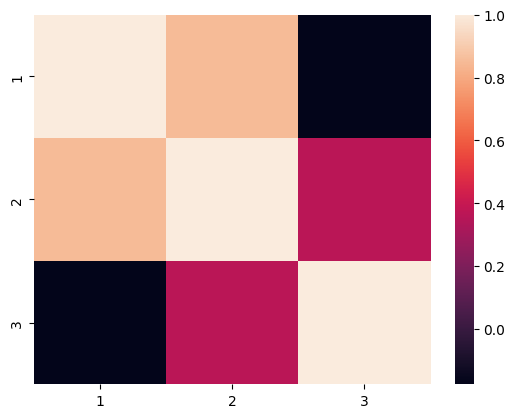

In [73]:
sns.heatmap(matrix_df_2)